In [1]:
import gym
import numpy as np
import ray
from really import SampleManager
from gridworlds import GridWorld
import random
import os

In [2]:
class TabularQ(object):

    def __init__(self, h, w, action_space):
        # Initialize q-table with zeros
        self.q_table = np.zeros((h, w, action_space))

    def __call__(self, state):
        output = {}
        output["q_values"] = self.q_table[tuple(state.T.astype("int"))]
        return output
    
    def get_weights(self):
        return self.q_table.copy()

    def set_weights(self, q_vals):
        assert q_vals.shape == self.q_table.shape
        self.q_table = q_vals

In [3]:
ray.init(log_to_driver=False)

2021-02-27 15:47:42,437	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.178.21',
 'raylet_ip_address': '192.168.178.21',
 'redis_address': '192.168.178.21:42921',
 'object_store_address': '/tmp/ray/session_2021-02-27_15-47-41_769502_232917/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-27_15-47-41_769502_232917/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-02-27_15-47-41_769502_232917',
 'metrics_export_port': 45779,
 'node_id': '50ac46ed8dcf9fee4922aa3827158cb2e7f8300ccb3315e9ad002a6c'}

In [7]:
action_dict = {0: "UP", 1: "RIGHT", 2: "DOWN", 3: "LEFT"}

env_kwargs = {
    "height": 3,
    "width": 4,
    "action_dict": action_dict,
    "start_position": (2, 0),
    "reward_position": (0, 3),
}

# you can also create your environment like this after installation: env = gym.make('gridworld-v0')
env = GridWorld(**env_kwargs)

model_kwargs = {"h": env.height, "w": env.width, "action_space": 4}

kwargs = {
    "model": TabularQ,
    "environment": GridWorld,
    "num_parallel": 2,
    "total_steps": 5,
    "model_kwargs": model_kwargs

    # and more
}

# initilize
manager = SampleManager(**kwargs)
# test
manager.get_data(do_print=True)

# where to save the results
saving_path = os.getcwd() + "./../Homework/A1/progress_test"
os.makedirs(saving_path, exist_ok=True)

buffer_size = 5000
test_steps = 1000
epochs = 12
sample_size = 1000
optim_batch_size = 8
alpha = 0.2
gamma = 0.85

# keys for replay buffer
optim_keys = ["state", "action", "reward", "state_new"]

# initialize buffer
manager.initilize_buffer(buffer_size, optim_keys)

# initilize progress aggregator
manager.initialize_aggregator(
    path=saving_path, saving_after=2, aggregator_keys=["td_error", "time_steps"]
)

iteration: 0, storing results of 1 runners


In [8]:
# initial testing:
print("test before training: ")
manager.test(test_steps, do_print=True)

# get initial agent
agent = manager.get_agent()

test before training: 
Episodes finished after a mean of 38.77 timesteps


collecting experience..
iteration: 0, storing results of 1 runners
collected data for: dict_keys(['state', 'action', 'reward', 'state_new'])
epoch ::: 0  td watkins error ::: 0.7468286150039107   avg env steps ::: 45.63
collecting experience..
iteration: 0, storing results of 1 runners
collected data for: dict_keys(['state', 'action', 'reward', 'state_new'])
epoch ::: 1  td watkins error ::: 0.12825702597684654   avg env steps ::: 4.0
collecting experience..
iteration: 0, storing results of 1 runners
collected data for: dict_keys(['state', 'action', 'reward', 'state_new'])
epoch ::: 2  td watkins error ::: 0.008068470850770407   avg env steps ::: 4.0
collecting experience..
iteration: 0, storing results of 1 runners
collected data for: dict_keys(['state', 'action', 'reward', 'state_new'])
epoch ::: 3  td watkins error ::: 0.00014299089109357733   avg env steps ::: 4.0
collecting experience..
iteration: 0, storing results of 1 runners
collected data for: dict_keys(['state', 'action', 'r

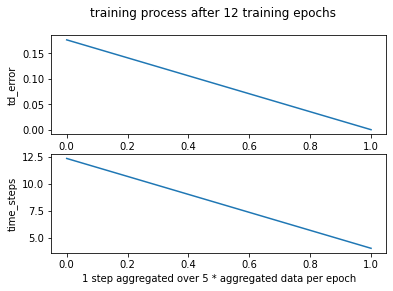

In [9]:
for e in range(epochs):
    print("collecting experience..")
    # Run agents
    data = manager.get_data(do_print=True)
    # avoid storing unnecessary data in buffer
    data = {key:value for key,value in data.items() if key in optim_keys}
    manager.store_in_buffer(data)
    
    # sample data as tf datasets to optimize on from buffer
    sample_dict = manager.buffer.sample_dictionary_of_datasets(sample_size) # Playing around with the framework
    print(f"collected data for: {sample_dict.keys()}")
    data_list = [dataset.batch(optim_batch_size) for dataset in sample_dict.values()]
    # get current q-values
    q_table = agent.get_weights().copy()
    
    td_errors = []
    for state, action, reward, next_state in zip(*data_list):
        # get tuple of index lists for state and actions dimensions
        state_action_pairs = tuple(np.concatenate((state, action[:,np.newaxis]), axis=1).astype("int").T.tolist())
        # get max q value of next state
        next_max_q_action = np.max(q_table[tuple(np.array(next_state, dtype="int").T.tolist())], axis=1)
        # compute watkins td error
        td_watkins_error = reward.numpy() + gamma * next_max_q_action - q_table[state_action_pairs]
        # update q-table
        q_table[state_action_pairs] += alpha * td_watkins_error       
        td_errors.append(np.mean(td_watkins_error))
        
    # print progress
    time_steps = manager.test(test_steps)
    manager.update_aggregator(td_error=td_errors, time_steps=time_steps)
    print(
        f"epoch ::: {e}  td watkins error ::: {np.mean(td_errors)}   avg env steps ::: {np.mean(time_steps)}"
    )
        
    # set new weights
    manager.set_agent(q_table)
    # get new weights
    agent = manager.get_agent()

In [116]:
manager.test(
       max_steps=100,
        test_episodes=10,
        render=True,
        do_print=True,
        evaluation_measure="time_and_reward",
    )

Episodes finished after a mean of 4.0 timesteps
Episodes finished after a mean of 2.0 accumulated reward


([4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])